In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping

# Load the dataset
file_path = 'updated_traffic.csv'
df = pd.read_csv(file_path)


In [2]:
df.head()

,DateTime,Junction,Vehicles,ID,Location
0,11/1/2015 0:00,1,15,20151101001,Indiranagar
1,11/1/2015 1:00,1,13,20151101011,Indiranagar
2,11/1/2015 2:00,1,10,20151101021,Indiranagar
3,11/1/2015 3:00,1,7,20151101031,Indiranagar
4,11/1/2015 4:00,1,9,20151101041,Indiranagar


In [4]:
df["Junction"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [3]:
print(f"Min Traffic: {df['Vehicles'].min()}")
print(f"Max Traffic: {df['Vehicles'].max()}")

Min Traffic: 0
Max Traffic: 206


In [4]:
# Convert the DateTime column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# Set DateTime as the index
df.set_index('DateTime', inplace=True)

In [5]:
# Select data for a specific junction
junction = 1
df_junction = df[df['Junction'] == junction]['Vehicles']

In [6]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_junction_scaled = scaler.fit_transform(df_junction.values.reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(df_junction_scaled) * 0.8)
train, test = df_junction_scaled[:train_size], df_junction_scaled[train_size:]

In [7]:
import pickle
# Save the scaler correctly
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved successfully!")

Scaler saved successfully!


In [8]:
# Create dataset function
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [9]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model with dropout and early stopping
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, kernel_regularizer='l2'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

c:\Users\Aspire_Lays\anaconda3\envs\torch\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Train the model with early stopping
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop],verbose=False)

In [11]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [12]:
# Create a new dataframe to align the predictions with the dates
train_predict_plot = np.empty_like(df_junction_scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_predict_plot = np.empty_like(df_junction_scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2):len(train_predict) + (look_back * 2) + len(test_predict), :] = test_predict

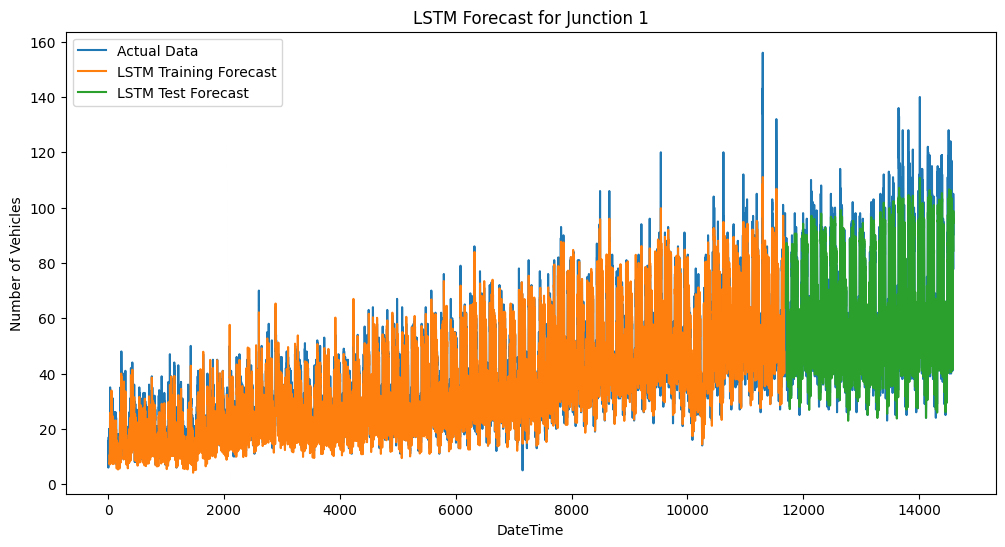

In [13]:
# Plot LSTM forecast
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df_junction_scaled), label='Actual Data')
plt.plot(train_predict_plot, label='LSTM Training Forecast')
plt.plot(test_predict_plot, label='LSTM Test Forecast')
plt.title('LSTM Forecast for Junction 1')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [14]:
# Performance evaluation
train_mse = mean_squared_error(y_train, train_predict)
train_mae = mean_absolute_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
test_mae = mean_absolute_error(y_test, test_predict)

In [15]:
# Calculate R² score and MAPE for additional accuracy evaluation
train_r2 = r2_score(y_train, train_predict)
test_r2 = r2_score(y_test, test_predict)
print(f'Train R²: {train_r2}')
print(f'Test R²: {test_r2}')

print(f'Train MSE with dropout and early stopping: {train_mse}')
print(f'Train MAE with dropout and early stopping: {train_mae}')
print(f'Test MSE with dropout and early stopping: {test_mse}')
print(f'Test MAE with dropout and early stopping: {test_mae}')

Train R²: 0.9376043438813612
Test R²: 0.9164491964898497
Train MSE with dropout and early stopping: 23.001844479262555
Train MAE with dropout and early stopping: 3.548349109921131
Test MSE with dropout and early stopping: 46.77896535780332
Test MAE with dropout and early stopping: 5.047566525553173


In [ ]:
#save the model
import joblib

# Save the model as .h5
model.save("lstm_traffic_model.h5")

['scaler.pkl']

In [19]:
import pickle
# Save the scaler correctly
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved successfully!")

Scaler saved successfully!


In [17]:
# Function to predict traffic
def predict_traffic(junction, date_time, look_back=24):
    date_time = pd.Timestamp(date_time)  # Ensure it's a Pandas Timestamp
    
    # Filter the junction-specific data
    df_junction = df[df["Junction"] == junction]["Vehicles"]

    # Convert index to datetime if not already
    df_junction.index = pd.to_datetime(df_junction.index)

    # Ensure the scaler is fit on the same data
    df_junction_scaled = scaler.fit_transform(df_junction.values.reshape(-1, 1))

    # Select the last `look_back` hours of data before the given date
    past_data = df_junction[df_junction.index < date_time].tail(look_back)  # ✅ FIXED

    # Ensure there is enough data to predict
    if len(past_data) < look_back:
        raise ValueError("Not enough historical data available!")

    # Scale input data
    X_input = past_data.values.reshape(-1, 1)
    X_scaled = scaler.transform(X_input)

    # Reshape for LSTM (1 sample, 24 time steps, 1 feature)
    X_scaled = np.reshape(X_scaled, (1, look_back, 1))

    # Make prediction
    predicted_traffic = model.predict(X_scaled)

    # Inverse transform to original scale
    predicted_traffic = scaler.inverse_transform(predicted_traffic.reshape(-1, 1))

    return int(predicted_traffic[0][0])  # Return as integer for easy interpretation

# Example usage
junction_id = 1
date_time = "2025-11-10 10:00:00"  # Change this to any valid timestamp in your dataset
predicted_vehicles = predict_traffic(junction_id, date_time)

print(f"Predicted vehicles at Junction {junction_id} on {date_time}: {predicted_vehicles}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted vehicles at Junction 1 on 2025-11-10 10:00:00: 76


In [18]:
# Example usage
junction_id = 14
date_time = "2025-11-10 10:00:00"  # Change this to any valid timestamp in your dataset
predicted_vehicles = predict_traffic(junction_id, date_time)

print(f"Predicted vehicles at Junction {junction_id} on {date_time}: {predicted_vehicles}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted vehicles at Junction 14 on 2025-11-10 10:00:00: 6
